# BioBert Multi-Label Text Classifier for Hallmarks-of-Cancers(HOC) corpus

The Hallmarks of Cancer  (*HOC) corpus consists of 1852 PubMed publication abstracts manually annotated by experts according to the Hallmarks of Cancer taxonomy. The taxonomy consists of 37 classes in a hierarchy. Zero or more class labels are assigned to each sentence in the corpus.

In this notebook we used BioBERT to do document classification. For more information on BioBert please see the followin link https://huggingface.co/dmis-lab/biobert-v1.1

# The required installations


*   Transformers
*   Pytorch Lightning
* Bert-extractive-summarizer for text summarization



In [ ]:
!pip install transformers
!pip install pytorch_lightning
!pip install bert-extractive-summarizer


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


# The imports

In [ ]:
import os
import re
import string
import json
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from sklearn import metrics
from torchmetrics import Accuracy
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)

[rank: 0] Global seed set to 42


42

# Processing the dataset

The raw dataset can be found at: https://github.com/sb895/Hallmarks-of-Cancer
There has been some processing done on the raw data and saved as the following XLSX file.

The processing done here on data are the following operations: 


1.   Removing symbols and oddly added spaces
2.   Removing the stopwords
3. Stemming
4. Lemmatizing


Instead of using the labels, we decided to conver the set of labels to one_hot_vector similar format. For each text entry there is coressponding 37 values of the labels. If the label applies to the text then it is 1 otherwise it is zero.

# The labels distribution over data

As mentioned earlier, there are 1850 documents labelled with one or more labels from the label set of 37. As we notice from the graph below the data is imbalanaced.



In [ ]:
data = pd.read_excel('L6.xlsx')

In [ ]:
sub_data = pd.read_excel('L7.xlsx')

In [ ]:
data.head()

,Text_files,L1,L2,L3,l4,L5,L6,L7,L8,L9,L10
0,Background .\nOver the past ten years oncologi...,0,0,0,0,0,0,1,0,0,1
1,Treatment for glioblastoma multiforme includes...,1,0,0,0,0,0,0,0,0,0
2,Prostate cancer ( PCA ) is the most common inv...,0,0,0,0,0,0,0,0,0,0
3,Splenic haemangiosarcomas ( HSAs ) from 122 do...,0,0,0,0,0,0,1,0,0,0
4,Application of adenovirus vectors ( Adv ) in m...,0,0,1,0,0,0,0,0,0,0


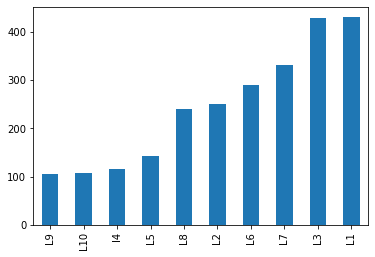

In [ ]:
ll = data.columns.tolist()[1:]
data[ll].sum().sort_values().plot(kind="bar");

In [ ]:
data['sum'] = data[ll].sum(axis=1)
data.head()

,Text_files,L1,L2,L3,l4,L5,L6,L7,L8,L9,L10,sum
0,Background .\nOver the past ten years oncologi...,0,0,0,0,0,0,1,0,0,1,2
1,Treatment for glioblastoma multiforme includes...,1,0,0,0,0,0,0,0,0,0,1
2,Prostate cancer ( PCA ) is the most common inv...,0,0,0,0,0,0,0,0,0,0,0
3,Splenic haemangiosarcomas ( HSAs ) from 122 do...,0,0,0,0,0,0,1,0,0,0,1
4,Application of adenovirus vectors ( Adv ) in m...,0,0,1,0,0,0,0,0,0,0,1


In [ ]:
# data = df


In [ ]:
data.shape

(1851, 12)

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=42)
val , test = train_test_split(data, test_size=0.1, random_state=42)

sub_train, sub_test = train_test_split(sub_data, test_size=0.3, random_state=42)
sub_val , sub_test = train_test_split(sub_data, test_size=0.1, random_state=42)

In [ ]:
train.head()

,Text_files,L1,L2,L3,l4,L5,L6,L7,L8,L9,L10,sum
1730,It is now largely accepted that ribosomal prot...,0,0,0,0,0,1,0,0,0,0,1
859,Mps one binder 1a ( MOB1A ) and MOB1B are key ...,0,0,0,0,0,0,1,1,0,0,2
208,Excessive exposure to solar UVA and UVB radiat...,0,0,0,0,0,0,0,0,0,0,0
1281,Peptide growth factors have been implicated in...,0,0,0,0,0,0,0,1,0,0,1
1450,A 33-year-old man presented with pain and pals...,1,0,0,1,0,0,0,0,0,0,2


In [ ]:
test.head()

,Text_files,L1,L2,L3,l4,L5,L6,L7,L8,L9,L10,sum
233,A growing number of studies have demonstrated ...,0,0,0,0,0,0,0,0,0,0,0
1567,BACKGROUND/AIMS Adenocarcinoma of the gallblad...,1,0,0,0,0,0,0,0,0,0,1
486,This article describes evaluation of plasma me...,0,0,0,0,0,1,0,0,0,0,1
799,"Each year , more than 700,000 people undergo c...",0,0,0,0,0,0,1,0,0,0,1
1233,As part of our program to develop breast cance...,1,0,0,0,0,0,0,0,0,0,1


In [ ]:
print(train.shape)
print(test.shape)

(1295, 12)
(186, 12)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
length = 0
for row in data['Text_files']:
  if length < len(row):
    length = len(row)
print(length)

4162


Cleaning the texts

In [ ]:
def clean_text(text):
    ''' Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

In [ ]:
def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shalsham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.tokenize import TreebankWordTokenizer

In [ ]:
stop_words = list(stopwords.words('english'))

In [ ]:
from transformers import AutoConfig

In [ ]:
from summarizer import Summarizer

custom_config = AutoConfig.from_pretrained('dmis-lab/biobert-v1.1')
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
custom_model = AutoModel.from_pretrained('dmis-lab/biobert-v1.1', config=custom_config)
smodel = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

In [ ]:
def summarize_text(text):
  summ = smodel(text, min_length = 60)
  return ''.join(summ)


In [ ]:
def remove_stop_words(text):
    text_tokenized = text.split()
    filtered_text = [w for w in text_tokenized if not w in stop_words]
    filtered_text = " ".join(filtered_text)
    
    return filtered_text

In [ ]:
def stemming_text(text):
    tokenizer = TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    porter = nltk.PorterStemmer()
    stemmed_text = [porter.stem(t) for t in tokens]
    final_text = " ".join(stemmed_text)
    return final_text


def lemmatizing_text(text):
    tokenizer = TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    wnl = nltk.WordNetLemmatizer()
    
    lemmatized_text = [wnl.lemmatize(t) for t in tokens]
    final_text = " ".join(lemmatized_text)
    return final_text

In [ ]:
def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = summarize_text(text) # Comment this line to turn off text summarization
    text = clean_text(text)
    text = remove_stop_words(text)
    text = remove_space(text)
    # text = stemming_text(text)
    # text = lemmatizing_text(text)
    return text

In [ ]:
def clean(df, text_field):
    df['cleaned_text'] = df[text_field].apply(lambda x: text_preprocessing_pipeline(str(x)))
    return df

In [ ]:
clean(train, 'Text_files')
clean(sub_train, 'Text_files')

<ipython-input-27-318079c7060b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df[text_field].apply(lambda x: text_preprocessing_pipeline(str(x)))
<ipython-input-27-318079c7060b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df[text_field].apply(lambda x: text_preprocessing_pipeline(str(x)))


,Text_files,Activating invasion and metastasis--Invasion,Inducing angiogenesis--By deregulating angiogenesis--Angiogenic factors,Evading growth suppressors--By deregulating cell cycle checkpoints--,Evading growth suppressors--By deregulating cell cycle checkpoints--Cell cycle,Evading growth suppressors--By evading contact inhibition,Avoiding immune destruction--Immune response,Genomic instability and mutation--Mutation,Tumor promoting inflammation--Inflammation--,Resisting cell death--Apoptosis,...,Resisting cell death--Necrosis,Genomic instability and mutation--DNA damage--Strand breaks,Sustaining proliferative signaling--Receptors,Sustaining proliferative signaling--Growth factors growth promoting signals--Downstream signaling,Inducing angiogenesis--By deregulating angiogenesis,Activating invasion and metastasis--Metastasis,Tumor promoting inflammation--Inflammation--Oxidative stress,Enabling replicative immortality--Senescence,Resisting cell death--Autophagy,cleaned_text
1730,It is now largely accepted that ribosomal prot...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,largely accepted ribosomal proteins may implic...
859,Mps one binder 1a ( MOB1A ) and MOB1B are key ...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,mps one binder key components hippo signaling ...
208,Excessive exposure to solar UVA and UVB radiat...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,excessive exposure solar uva uvb radiation wid...
1281,Peptide growth factors have been implicated in...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,peptide growth factors implicated progression ...
1450,A 33-year-old man presented with pain and pals...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,year old man presented pain palsy leg treatmen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,OBJECTIVE Hepatocellular carcinoma ( HCC ) is ...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,objective hepatocellular carcinoma hcc highly ...
1294,Cav-1 ( -/- ) deficient stromal cells are a ne...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,cav deficient stromal cells new genetic model ...
860,The NOTCH signaling pathway plays important ro...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,notch signaling pathway plays important role d...
1459,Imiquimod is a synthetic compound with antitum...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,imiquimod synthetic compound antitumor propert...


In [ ]:
clean(test, 'Text_files')
clean(sub_test, 'Text_files')

<ipython-input-27-318079c7060b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df[text_field].apply(lambda x: text_preprocessing_pipeline(str(x)))
<ipython-input-27-318079c7060b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df[text_field].apply(lambda x: text_preprocessing_pipeline(str(x)))


,Text_files,Activating invasion and metastasis--Invasion,Inducing angiogenesis--By deregulating angiogenesis--Angiogenic factors,Evading growth suppressors--By deregulating cell cycle checkpoints--,Evading growth suppressors--By deregulating cell cycle checkpoints--Cell cycle,Evading growth suppressors--By evading contact inhibition,Avoiding immune destruction--Immune response,Genomic instability and mutation--Mutation,Tumor promoting inflammation--Inflammation--,Resisting cell death--Apoptosis,...,Resisting cell death--Necrosis,Genomic instability and mutation--DNA damage--Strand breaks,Sustaining proliferative signaling--Receptors,Sustaining proliferative signaling--Growth factors growth promoting signals--Downstream signaling,Inducing angiogenesis--By deregulating angiogenesis,Activating invasion and metastasis--Metastasis,Tumor promoting inflammation--Inflammation--Oxidative stress,Enabling replicative immortality--Senescence,Resisting cell death--Autophagy,cleaned_text
233,A growing number of studies have demonstrated ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,growing number studies demonstrated associatio...
1567,BACKGROUND/AIMS Adenocarcinoma of the gallblad...,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,background aims adenocarcinoma gallbladder hig...
486,This article describes evaluation of plasma me...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,article describes evaluation plasma membrane f...
799,"Each year , more than 700,000 people undergo c...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"year , , people undergo cancer surgery united ..."
1233,As part of our program to develop breast cance...,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,part program develop breast cancer specific th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,Many tumors contain heterogeneous populations ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,many tumors contain heterogeneous populations ...
1078,Colon cancer is a leading cause of morbidity a...,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,colon cancer leading cause morbidity mortality...
124,IL-16 is a ligand and chemotactic factor for C...,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,il inhibits mediated lymphocyte activation pro...
733,BACKGROUND The uneven distribution of recombin...,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,background uneven distribution recombination a...


In [ ]:
clean(val, 'Text_files')
clean(sub_val, 'Text_files')

<ipython-input-27-318079c7060b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df[text_field].apply(lambda x: text_preprocessing_pipeline(str(x)))
<ipython-input-27-318079c7060b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df[text_field].apply(lambda x: text_preprocessing_pipeline(str(x)))


,Text_files,Activating invasion and metastasis--Invasion,Inducing angiogenesis--By deregulating angiogenesis--Angiogenic factors,Evading growth suppressors--By deregulating cell cycle checkpoints--,Evading growth suppressors--By deregulating cell cycle checkpoints--Cell cycle,Evading growth suppressors--By evading contact inhibition,Avoiding immune destruction--Immune response,Genomic instability and mutation--Mutation,Tumor promoting inflammation--Inflammation--,Resisting cell death--Apoptosis,...,Resisting cell death--Necrosis,Genomic instability and mutation--DNA damage--Strand breaks,Sustaining proliferative signaling--Receptors,Sustaining proliferative signaling--Growth factors growth promoting signals--Downstream signaling,Inducing angiogenesis--By deregulating angiogenesis,Activating invasion and metastasis--Metastasis,Tumor promoting inflammation--Inflammation--Oxidative stress,Enabling replicative immortality--Senescence,Resisting cell death--Autophagy,cleaned_text
344,Several basic leucine zipper ( B-ZIP ) transcr...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,several basic leucine zipper b zip transcripti...
1444,It is well established that blocking the inter...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,well established blocking interaction egfr gro...
408,Genipin is a metabolite of geniposide isolated...,1,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,genipin metabolite geniposide isolated extract...
49,BACKGROUND Modulation of the expression of ret...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,background modulation expression retinoic acid...
342,Metastatic breast tumors undergo epithelial-to...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,metastatic breast tumors undergo epithelial me...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,OBJECTIVE Hepatocellular carcinoma ( HCC ) is ...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,objective hepatocellular carcinoma hcc highly ...
1294,Cav-1 ( -/- ) deficient stromal cells are a ne...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,cav deficient stromal cells new genetic model ...
860,The NOTCH signaling pathway plays important ro...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,notch signaling pathway plays important role d...
1459,Imiquimod is a synthetic compound with antitum...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,imiquimod synthetic compound antitumor propert...


In [ ]:
def change_dtype(value):
    try:
        return int(value)
    except ValueError:
        try:
            return float(value)
        except ValueError:
            return value

In [ ]:
target_cols = [col for col in train.columns if col not in ['Text_files', 'cleaned_text', 'sum']]
target_cols

['L1', 'L2', 'L3', 'l4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10']

In [ ]:
Label_0= 'Sustaining proliferative signalling'
Label_1= 'Evading growth suppressors'
Label_2= 'Resisting cell death'
Label_3= 'Enabling replicative immortality'
Label_4= 'Inducing angiogenesis'
Label_5= 'Activating invasion and metastasis'
Label_6= 'Genomic instability and mutation'
Label_7= 'Tumor promoting inflammation'
Label_8= 'Cellular energetics'
Label_9= 'Avoiding immune destruction'

In [ ]:
sub_target_cols = [col for col in sub_train.columns if col not in ['Text_files', 'cleaned_text', 'sum']]
for i in range(len(sub_target_cols)):
    print(i," : ", sub_target_cols[i])

0  :  Activating invasion and metastasis--Invasion
1  :  Inducing angiogenesis--By deregulating angiogenesis--Angiogenic factors
2  :  Evading growth suppressors--By deregulating cell cycle checkpoints--
3  :  Evading growth suppressors--By deregulating cell cycle checkpoints--Cell cycle
4  :  Evading growth suppressors--By evading contact inhibition
5  :  Avoiding immune destruction--Immune response
6  :  Genomic instability and mutation--Mutation
7  :  Tumor promoting inflammation--Inflammation--
8  :  Resisting cell death--Apoptosis
9  :  Enabling replicative immortality--Immortalization
10  :  Avoiding immune destruction--Immunosuppression
11  :  Genomic instability and mutation--DNA damage--Adducts
12  :  Genomic instability and mutation--DNA damage--
13  :  Sustaining proliferative signaling--Cell cycle
14  :  Cellular energetics--Glycolysis/Warburg effect
15  :  Genomic instability and mutation--DNA repair mechanisms
16  :  Sustaining proliferative signaling--Growth factors grow

In [ ]:
L0 = [13,16,20,21]
L1 = [2,3,4]
L2 = [8,18,26]
L3 = [9,25]
L4 = [1,22]
L5 = [0,23]
L6 = [6,11,12,15,19]
L7 = [7,17,24]
L8 = [14]
L9 = [5,10]
L_all = []
L_all.append(L0)
L_all.append(L1)
L_all.append(L2)
L_all.append(L3)
L_all.append(L4)
L_all.append(L5)
L_all.append(L6)
L_all.append(L7)
L_all.append(L8)
L_all.append(L9)

In [ ]:
for column in target_cols:
    train.loc[:, column] = train[column].apply(change_dtype)
for column in sub_target_cols:
    sub_train.loc[:, column] = sub_train[column].apply(change_dtype)

/share/apps/rc/software/Anaconda3/2020.07/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
for column in target_cols:
    val.loc[:, column] = val[column].apply(change_dtype)
for column in sub_target_cols:
    sub_val.loc[:, column] = sub_val[column].apply(change_dtype)

In [ ]:
for column in target_cols:
    test.loc[:, column] = test[column].apply(change_dtype)
for column in sub_target_cols:
    sub_test.loc[:, column] = sub_test[column].apply(change_dtype)

In [ ]:
MAX_LEN = 0
for row in train['cleaned_text']:
  if MAX_LEN < len(row):
    MAX_LEN = len(row)

print(MAX_LEN)

920


In [ ]:
MAX_LEN1 = 0
for row in val['cleaned_text']:
  if MAX_LEN1 < len(row):
    MAX_LEN1 = len(row)

print(MAX_LEN1)

920


In [ ]:
MAX_LEN1 = 0
for row in test['cleaned_text']:
  if MAX_LEN1 < len(row):
    MAX_LEN1 = len(row)

print(MAX_LEN1)

560


In [ ]:
train.reset_index(inplace=False)
train.head()

,Text_files,L1,L2,L3,l4,L5,L6,L7,L8,L9,L10,sum,cleaned_text
1730,It is now largely accepted that ribosomal prot...,0,0,0,0,0,1,0,0,0,0,1,largely accepted ribosomal proteins may implic...
859,Mps one binder 1a ( MOB1A ) and MOB1B are key ...,0,0,0,0,0,0,1,1,0,0,2,mps one binder key components hippo signaling ...
208,Excessive exposure to solar UVA and UVB radiat...,0,0,0,0,0,0,0,0,0,0,0,excessive exposure solar uva uvb radiation wid...
1281,Peptide growth factors have been implicated in...,0,0,0,0,0,0,0,1,0,0,1,peptide growth factors implicated progression ...
1450,A 33-year-old man presented with pain and pals...,1,0,0,1,0,0,0,0,0,0,2,year old man presented pain palsy leg treatmen...


In [ ]:
test.reset_index(inplace=True)

# The hyperparameters declaration

In [ ]:
TRAIN_BATCH_SIZE = 12
VALID_BATCH_SIZE = 12
EPOCHS = 10
LEARNING_RATE = 1e-5
BERT_MODEL_NAME = 'dmis-lab/biobert-v1.1'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

# The dataset function
This function will take a row from the dataframe and returns the cleaned text, the corresponding labels, input ids, token type ids and the attention mask

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df['cleaned_text'].values
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text =  str(self.text[index]) #self.text.iloc[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
class BERT_sub_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df['cleaned_text'].values
        self.tokenizer = tokenizer
        self.targets = df[sub_target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text =  str(self.text[index]) #self.text.iloc[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

# The data set module which inherits from `pl.LightningDataModule`. Takes a data set and returns a data loader

In [ ]:
class DataModule(pl.LightningDataModule):
    def __init__(self, train, test, batch_size: int = 12):
        super().__init__()
        self.train = train
        self.test = val
        self.batch_size = batch_size

    def setup(self, stage: str):
        self.bert_train = BERTDataset(self.train, tokenizer, 510)
        self.bert_test = BERTDataset(self.test, tokenizer, 510)

    def train_dataloader(self):
        return DataLoader(self.bert_train, batch_size=TRAIN_BATCH_SIZE, 
                          num_workers=0, shuffle=False)

    def val_dataloader(self):
        return DataLoader(self.bert_test, batch_size=TRAIN_BATCH_SIZE, 
                          num_workers=0, shuffle=False)

In [ ]:
class sub_DataModule(pl.LightningDataModule):
    def __init__(self, train, test, batch_size: int = 12):
        super().__init__()
        self.train = sub_train
        self.test = sub_val
        self.batch_size = batch_size

    def setup(self, stage: str):
        self.bert_train = BERT_sub_Dataset(self.train, tokenizer, 510)
        self.bert_test = BERT_sub_Dataset(self.test, tokenizer, 510)

    def train_dataloader(self):
        return DataLoader(self.bert_train, batch_size=TRAIN_BATCH_SIZE, 
                          num_workers=0, shuffle=False)

    def val_dataloader(self):
        return DataLoader(self.bert_test, batch_size=TRAIN_BATCH_SIZE, 
                          num_workers=0, shuffle=False)

In [ ]:
lightning_data = DataModule(train, val)

In [ ]:
lightning_sub_data = sub_DataModule(sub_train, sub_val)

# The loss functions

For calculatin the loss we are using Binary Crossentropy loss function

In [ ]:
criterion = nn.BCELoss()

# The classifier model:

This is the classifier model. This model is based on BioBert. The model take the input and pass it through a classifiction linear linear which will output 37 predictions. The prediction is passed to a sigmoid function to produce probablities for each label class. 
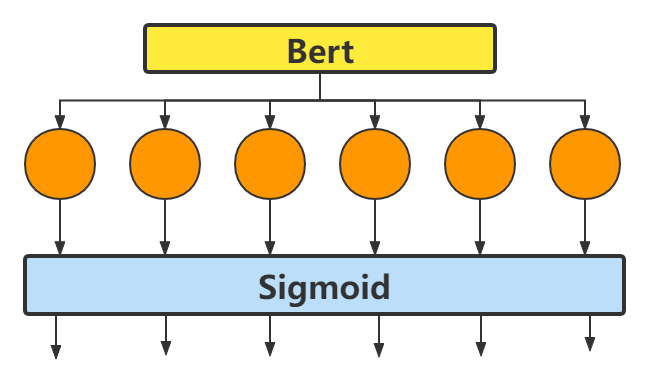

The training and validation steps are straightforward using the Pytorch Lightning module. 

In [ ]:
class MultiLabelClassifier(pl.LightningModule):
    def __init__(self, num_classes=None):
        super().__init__()
        self.num_classes=num_classes
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.linear = nn.Linear(768, self.num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.linear(output.pooler_output)
        output = torch.sigmoid(output)
        return output
    
    def training_step(self, batch, batch_idx):
#         print(batch_idx)
        ids = batch["ids"]
        mask = batch["mask"]
        labels = batch["targets"]
        outputs = self(ids, mask, labels)
        loss = criterion(outputs, labels)
        return {"loss": loss}
    
    def validation_step(self, batch, batch_idx):
        ids = batch["ids"]
        mask = batch["mask"]
        labels = batch["targets"]
        outputs = self(ids, mask, labels)
        loss = criterion(outputs, labels)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=5e-5)#, weight_decay=1e-6)

# Fitting th model
The model runs on 3 epochs  and using `auto_lr_find` from Pytorch Lightning


For training deep neural networks, selecting a good learning rate is essential for both better performance and faster convergence. Even optimizers such as Adam that are self-adjusting the learning rate can benefit from more optimal choices.

To reduce the amount of guesswork concerning choosing a good initial learning rate, a learning rate finder can be used. As described in this paper a learning rate finder does a small run where the learning rate is increased after each processed batch and the corresponding loss is logged. The result of this is a lr vs. loss plot that can be used as guidance for choosing a optimal initial lr.
For more information:https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html

In [ ]:
trainer = Trainer(max_epochs=3, accelerator='gpu',auto_lr_find=True)
model = MultiLabelClassifier(10)
trainer.fit(model, lightning_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type      | Params
-------------------------------------
0 | bert   | BertModel | 108 M 
1 | linear | Linear    | 7.7 K 
-------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.272   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/home/shalsham/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/shalsham/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
trainer = Trainer(max_epochs=3, accelerator='gpu',auto_lr_find=True)
sub_model = MultiLabelClassifier(27)
trainer.fit(sub_model, lightning_sub_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/shalsham/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:601: UserWarning: Checkpoint directory /data/user/home/shalsham/UAB_NLP_MLC_WSD/lightning_logs/version_17728416/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type      | Params
-------------------------------------
0 | bert   | BertModel | 108 M 
1 | linear | Linear    | 20.8 K
-------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.324   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


# Running the model on the test set and calculating the accuracy

In [ ]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
trained_model = model.to(device)
trained_sub_model = sub_model.to(device)
train_dataset = BERTDataset(
  test.iloc[:75],
  tokenizer,
  510
)

preds = []
labels = []
for item in tqdm(train_dataset):
  pred = trained_model(
    item["ids"].unsqueeze(dim=0).to(device),
    item["mask"].unsqueeze(dim=0).to(device)
  )
  preds.append(pred.flatten())
  labels.append(item['targets'].int())
preds = torch.stack(preds).detach().cpu()
labels = torch.stack(labels).detach().cpu()

sub_preds = []
sub_labels = []
train_dataset = BERT_sub_Dataset(
  sub_test.iloc[:75],
  tokenizer,
  510
)
for item in tqdm(train_dataset):
  pred = trained_sub_model(
    item["ids"].unsqueeze(dim=0).to(device),
    item["mask"].unsqueeze(dim=0).to(device)
  )
  sub_preds.append(pred.flatten())
  sub_labels.append(item['targets'].int())
sub_preds = torch.stack(sub_preds).detach().cpu()
sub_labels = torch.stack(sub_labels).detach().cpu()

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
accuracy = Accuracy(threshold=0.25)

In [ ]:
accuracy(preds, labels)

tensor(0.8120)

# A look into a predction sample:

In [ ]:
sub_accuracy = Accuracy(threshold=0.10)

In [ ]:
sub_accuracy(sub_preds, sub_labels)

tensor(0.8528)

In [ ]:
print("Model's prediction")
for i in range(10):
    if preds[5][i] >= 0.25:
        for j in range(27):
            if j in L_all[i] and sub_preds[5][j] >= 0.1:
                print(sub_target_cols[j])
print("True Labels")
for i in range(27):
    if sub_labels[5][i] >0:
        print(i,sub_target_cols[i])

Model's prediction
Sustaining proliferative signaling--Cell cycle
Sustaining proliferative signaling--Receptors
True Labels
13 Sustaining proliferative signaling--Cell cycle
20 Sustaining proliferative signaling--Receptors


#Discussion & Limitations

Although the model works and give correct results to some extent there is still the issue of the inbalanced data which can cause the dominant class to apper often.

To tackle the imbalanced data issues I have tried the following approaches, yet there is not much of a difference:
1- Downsampling data. I did it manually due to the lack of sampling libraries for multi label datasets.The work can be found in the ImbFix notebook in the alternative_approaches folder. It is very simple and straightforward approach as I tried to lower the dominant class appearence in the dataframe.

2- I tried adjusting weights in this model, but I didn't see a real difference in the results.


The limitation I encountered is that BioBert only takes 512 tokens and some of the documents in the data reached 4000+ words. I treid truncating from the head of the data and also truncating from the middle, yet truncating the tail gave better results. 

I tried to implement a larger model `BioLinkBert` which can take upto 1024, however the gpus always runs out of memory during training.

I was also working on a nother approach which is chunking text and taking average results from each documen. The notebook can be found as well in the alternative_aproaches folder. I didn't get to finish the model because of the time limit, but I believe it could have provided better results.


#Future Work

I will try to enhance the current model and finish the chunking approach as soon as I can, however I generally believe if the dataset could be balanced, better accuracy and results will show.